# Notebook Setup

In [30]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    # MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/TFT_baseline"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    # MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"
    MY_HOME_ABS_PATH = "/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling"

## Import Modules

In [65]:
import os
os.chdir(MY_HOME_ABS_PATH)

import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters, MetricsCallback
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import optuna
from optuna.integration import PyTorchLightningPruningCallback, TensorBoardCallback

# from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle


# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib_for_nbinstance import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

Global seed set to 42


42

In [3]:
# data/models/tft_model_1yrtrain_tuning_230318_1906/trial_0/epoch=12.ckpt

## Define Local File System Constants

In [32]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'
model_objects_dir = root_dir + os.sep + 'code/src/modeling/model_objects'

# Load Train and Test dataset from Azure Storage Blob

In [33]:
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

local_file = tmp_dir + os.sep + blob_name

In [34]:
# def get_raw_datasets(container, blob_name):
local_file = tmp_dir + os.sep + blob_name
data_df = None
if not (os.path.exists(local_file)):
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container, blob_name)
    data_df = pd.read_parquet(file_stream, engine='pyarrow')
    data_df.to_parquet(local_file)
else:
    data_df = pd.read_parquet(local_file)

print(f"Data size: {data_df.shape}")

# Convert Dtypes
cat_cols = ["year", "month", "day", "hour", "MODIS_IGBP", "koppen_main", "koppen_sub", 
            "gap_flag_month", "gap_flag_hour"]
for col in cat_cols:
    data_df[col] = data_df[col].astype(str).astype("category")

print(f"Data Columns: {data_df.columns}")
print(f"NA count: {data_df.isna().sum().sum()}")
# return data_df

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Load Three Best Models As of April 8

In [35]:
!pwd
model_dir
MY_HOME_ABS_PATH

/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling


'/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling'

In [73]:
best_model_path_GPP = f"{MY_HOME_ABS_PATH}/data/models/tft_model_1yrtrain_tuning_230318_1906/trial_0/epoch=12.ckpt"
# best_model_path_NO_GPP: 
# full: 
# slim: Gain from "tft_model_15_tft_nogpp_small_lr_230405_0227"
# best_model_path_TreeFT = f"{model_dir}tft_model_1YrTrain_3DEncode_RFRGPP_230329_0107/lightning_logs/version_0/checkpoints/epoch=8-step=11907.ckpt"

In [74]:
best_GPP = TemporalFusionTransformer.load_from_checkpoint(best_model_path_GPP)
# best_NO_GPP = TemporalFusionTransformer.load_from_checkpoint(best_model_path_NO_GPP)
# best_TreeFT = TemporalFusionTransformer.load_from_checkpoint(best_model_path_TreeFT)
print(f"Quantiles: {best_GPP.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# print(f"Quantiles: {best_NO_GPP.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# print(f"Quantiles: {best_TreeFT.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


# Make prediction for three best models

### Define TS Dataset(two types)

In [66]:
# Use this instead!!
def setup_tsdataset(train_df, val_df, test_df, min_encoder_len):
    # create training and validation TS dataset 
    training = TimeSeriesDataSet(
      train_df, # <------ no longer subsetting, option 1 split can use entire train site sequence
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["year", "month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=["GPP_NT_VUT_REF"],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)

In [39]:
def setup_tsdataset_nogpp_slim(train_df, val_df, test_df, min_encoder_len):
    training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False,
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main"],
      static_reals=[],
      time_varying_known_categoricals=["month", "hour"],
      time_varying_known_reals=['TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'BESS-RSDN',],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=[],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False,
      add_encoder_length=False,
    )

    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
    
    if test_df is not None:
        testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
    else:
        testing = None

    return (training, validation, testing)


# setup datasets data
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
training, validation, _ = setup_tsdataset_nogpp_slim(train_df, val_df, None, ENCODER_LEN)

Subest length: 8760 timesteps for each sites
Subset num train timesteps: 683280
Subset num val timesteps: 227760


Setup batch size

In [40]:
# create dataloaders for model
batch_size = 64
cpu_count = os.cpu_count()

## Create TS Dataset

In [67]:
# Experiment constants
VAL_INDEX = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365 # 1 year
ENCODER_LEN =  24*7
print(f"training timestemp length= {SUBSET_LEN}")

# Setup dataset
train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)

training timestemp length= 8760
Subest length: 8760 timesteps for each sites
Subset num train timesteps: 683280
Subset num val timesteps: 227760
Subset num test timesteps: 219000


### GPP-TFT

In [68]:
(training_GPP, validation_GPP, testing_GPP) = setup_tsdataset(train_df, val_df, test_df, ENCODER_LEN)

In [19]:
# # Get small test data
# subtest_df = test_df.loc[test_df['timestep_idx_local'] < ENCODER_LEN+5, ].copy()
# _, _, subtesting = setup_tsdataset(train_df, val_df, subtest_df, ENCODER_LEN)
# print(f"Subset num subtest timesteps: {len(subtest_df)}")

# # create dataloaders for model
# # ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
# batch_size = 64  # set this between 32 to 128
# cpu_count = os.cpu_count()

### Define TS Dataset for NO-PAST-GPP models

In [20]:
# (training_NO_PAST_GPP, validation_NO_PAST_GPP, testing_NO_PAST_GPP) = setup_tsdataset_no_past_GPP(train_df, val_df, test_df, ENCODER_LEN)


In [21]:
# # Get small test data
# subtest_df = test_df.loc[test_df['timestep_idx_local'] < ENCODER_LEN+5, ].copy()
# _, _, subtesting = setup_tsdataset(train_df, val_df, subtest_df, ENCODER_LEN)
# print(f"Subset num subtest timesteps: {len(subtest_df)}")

# # create dataloaders for model
# # ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
# batch_size = 64  # set this between 32 to 128
# cpu_count = os.cpu_count()

In [72]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=cpu_count, pin_memory=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count, pin_memory=False)

# # Create TFT model from dataset
# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=0.00001,
#     hidden_size=16,  # most important hyperparameter apart from learning rate
#     attention_head_size=1, # Set to up to 4 for large datasets
#     dropout=0.3, # Between 0.1 and 0.3 are good values
#     hidden_continuous_size=16,  # set to <= hidden_size
#     output_size=7,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     logging_metrics=nn.ModuleList([MAE(), RMSE()]),
#     reduce_on_plateau_patience=2, # reduce learning rate if no improvement in validation loss after x epochs
#     optimizer="adam"
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# # configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=6, mode="min", check_finite=True, verbose=False,)
# lr_logger = LearningRateMonitor()  # log the learning rate
# checkpoint_callback = ModelCheckpoint(dirpath=exp_model_dir, save_top_k=3, monitor="val_loss") # save model objects for top k epoch val loss
# logger = TensorBoardLogger(exp_model_dir)  # logging results to a tensorboard

# trainer = pl.Trainer(
#     max_epochs=25,
#     enable_model_summary=True,
#     #gradient_clip_val=2,
#     fast_dev_run=False, 
#     accelerator='gpu',
#     devices="auto", 
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger,
#     strategy="ddp",
# )

## Prepare Two Validation Data Loaders

In [23]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [24]:
# Eval on Validation set
val_dataloader_GPP = validation_GPP.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# Print Model Eval on Validation Set
val_actuals_GPP = torch.cat([y[0] for x, y in iter(val_dataloader_GPP)])

In [25]:
# Eval on Validation set
val_dataloader_GPP = validation_GPP.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

# Print Model Eval on Validation Set
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader_GPP)])


In [26]:
# save eval results - also we can resume eval at a later point in time

with open("val_actuals_best_GPP_TFT_April8.pkl", "wb") as fout:
    pickle.dump(val_actuals_GPP, fout)

In [49]:
!pwd

/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling


In [27]:
# import boto3
# import json
# from io import StringIO
# create an S3 client
# s3_client = boto3.client('s3')

# bucket_name = 'rumi-store-prediction-result'
# file_name = "val_actuals_best_GPP_TFT_April8.pkl"

# # upload the file to S3
# s3_client.upload_file(file_name, bucket_name,
#                       "/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling")

In [53]:
# create a large dictionary
# my_dict = {...}  # your large dictionary here

# serialize the dictionary to a JSON-formatted string
# json_string = json.dumps(my_dict)

# # create a StringIO buffer to hold the JSON string in memory
# buffer = StringIO(json_string)

# # upload the buffer to S3
# bucket_name = 'your-bucket-name'
# file_name = 'your-file-name.json'
# s3_client.put_object(Body=buffer.getvalue(), Bucket=bucket_name, Key=file_name)

# Prediction on three best models

## Best GPP

In [43]:
print(f"Start eval on validation.")
start = default_timer()
val_raw_pred_GPP, val_x_GPP = best_GPP.predict(val_dataloader_GPP, mode="raw", show_progress_bar=True, return_x=True)
eval_time = default_timer() - start
print(f"Val eval time: {eval_time}")

Start eval on validation.


Predict: 100%|██████████| 3491/3491 [16:37<00:00,  3.50 batches/s]

Val eval time: 997.9933671140002


In [54]:
# Store raw_predictions
val_raw_predictions = {}
for i in val_raw_pred_GPP.keys():
    val_raw_predictions[i] = val_raw_pred_GPP[i]
val_raw_predictions.keys()

dict_keys(['prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths'])

In [60]:
# Store x
val_x = {}
for i in val_x_GPP.keys():
    val_x[i] = val_x_GPP[i]
val_x.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [ ]:
# tft_model_16_tft_nogpp_7D_small_lr_230406_0405

In [ ]:
# print(f"Start eval on validation.")
# start = default_timer()
# val_raw_pred_NO_GPP, val_x_NO_GPP = best_NO_GPP.predict(val_dataloader, mode="raw", show_progress_bar=True, return_x=True)
# eval_time = default_timer() - start
# print(f"Val eval time: {eval_time}")

In [ ]:
# Store raw_predictions
val_raw_predictions_store = {}
for i in val_raw_pred_NO_GPP.keys():
  val_raw_predictions_store[i] = val_raw_pred_NO_GPP[i]

with open('val_raw_predictions_best_NO_GPP_april4.pkl', 'wb') as handle:
    pickle.dump(val_raw_predictions_store, handle, protocol=pickle.HIGHEST_PROTOCOL)
# open pickle from storage
with open('val_raw_predictions_best_NO_GPP_april4.pkl', 'rb') as handle:
    raw_predictions_NO_GPP = pickle.load(handle)

print(raw_predictions_NO_GPP.keys())

In [ ]:
# Store x
val_x_store = {}
for i in val_x_NO_GPP.keys():
  val_x_store[i] = val_x_NO_GPP[i]

with open('val_x_best_NO_GPP_april4.pkl', 'wb') as handle:
    pickle.dump(val_x_store, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('val_x_best_NO_GPP_april4.pkl', 'rb') as handle:
    x_NO_GPP = pickle.load(handle)

print(x_NO_GPP.keys())

# Model Interpretation

In [139]:
print(f'encoder variables: {best_GPP.encoder_variables}')
encoder_var = best_GPP.encoder_variables
len(best_GPP.encoder_variables)

encoder variables: ['year', 'month', 'day', 'hour', 'gap_flag_month', 'gap_flag_hour', 'timestep_idx_global', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'relative_time_idx', 'GPP_NT_VUT_REF']


38

### Interpret_output
- reduction: "none" for no averaging over batches, 
- "sum" for summing attentions, 
- "mean" for normalizing by encode lengths
- attention_prediction_horizon: which prediction horizon to use for attention

In [97]:
interpretation_none = best_tft.interpret_output(val_raw_predictions, reduction="none")
interpretation_sum = best_tft.interpret_output(val_raw_predictions, reduction="sum")
interpretation_mean = best_tft.interpret_output(val_raw_predictions, reduction="mean")

In [102]:
# size of val_raw_predictions['encoder_variables']
print(val_raw_predictions['encoder_variables'].shape)

torch.Size([223392, 168, 1, 38])


When encoder length is 24 times 7, Each feature has 168 feature importance in each prediction time point

In [ ]:
print(val_raw_predictions['encoder_variables'][0].shape)
val_raw_predictions['encoder_variables'][0]


torch.Size([168, 1, 38])


tensor([[[0.0198, 0.0169, 0.0022,  ..., 0.0044, 0.0297, 0.2181]],

        [[0.0197, 0.0169, 0.0022,  ..., 0.0044, 0.0296, 0.2263]],

        [[0.0197, 0.0168, 0.0022,  ..., 0.0044, 0.0295, 0.2199]],

        ...,

        [[0.0188, 0.0161, 0.0023,  ..., 0.0043, 0.0282, 0.2545]],

        [[0.0190, 0.0163, 0.0023,  ..., 0.0043, 0.0286, 0.2455]],

        [[0.0185, 0.0159, 0.0023,  ..., 0.0043, 0.0278, 0.2697]]])

In [165]:
print(val_raw_predictions['encoder_variables'][0][0].shape)
val_raw_predictions['encoder_variables'][0][0]

torch.Size([1, 38])


tensor([[0.0198, 0.0169, 0.0022, 0.0074, 0.0087, 0.0943, 0.0205, 0.0240, 0.1229,
         0.0274, 0.0250, 0.0046, 0.0256, 0.0160, 0.0203, 0.0012, 0.0205, 0.0265,
         0.0048, 0.0134, 0.0223, 0.0241, 0.0117, 0.0217, 0.0058, 0.0223, 0.0063,
         0.0207, 0.0059, 0.0357, 0.0211, 0.0017, 0.0209, 0.0058, 0.0198, 0.0044,
         0.0297, 0.2181]])

In [133]:
print(len(val_raw_predictions['encoder_variables'][0][0][0]))
print(val_raw_predictions['encoder_variables'][0][0].sum())
val_raw_predictions['encoder_variables'][0][0]

38
tensor(1.0000)


tensor([[0.0198, 0.0169, 0.0022, 0.0074, 0.0087, 0.0943, 0.0205, 0.0240, 0.1229,
         0.0274, 0.0250, 0.0046, 0.0256, 0.0160, 0.0203, 0.0012, 0.0205, 0.0265,
         0.0048, 0.0134, 0.0223, 0.0241, 0.0117, 0.0217, 0.0058, 0.0223, 0.0063,
         0.0207, 0.0059, 0.0357, 0.0211, 0.0017, 0.0209, 0.0058, 0.0198, 0.0044,
         0.0297, 0.2181]])

### Interpretation reduction="none"

In [135]:
print(interpretation_none['encoder_variables'].shape)
interpretation_none['encoder_variables']

torch.Size([223392, 38])


tensor([[0.0316, 0.0175, 0.0031,  ..., 0.0120, 0.0310, 0.1549],
        [0.0316, 0.0175, 0.0031,  ..., 0.0120, 0.0310, 0.1549],
        [0.0316, 0.0175, 0.0031,  ..., 0.0120, 0.0310, 0.1549],
        ...,
        [0.0270, 0.0187, 0.0021,  ..., 0.0105, 0.0314, 0.1708],
        [0.0269, 0.0187, 0.0021,  ..., 0.0104, 0.0313, 0.1719],
        [0.0267, 0.0187, 0.0021,  ..., 0.0103, 0.0313, 0.1729]])

In [113]:
print(interpretation_none['encoder_variables'][0].sum())
interpretation_none['encoder_variables'][0]

tensor(1.0000)


tensor([0.0316, 0.0175, 0.0031, 0.0066, 0.0094, 0.0653, 0.0306, 0.0250, 0.1304,
        0.0283, 0.0268, 0.0047, 0.0279, 0.0119, 0.0218, 0.0028, 0.0221, 0.0270,
        0.0042, 0.0454, 0.0182, 0.0258, 0.0143, 0.0181, 0.0113, 0.0310, 0.0129,
        0.0224, 0.0044, 0.0325, 0.0137, 0.0045, 0.0228, 0.0079, 0.0203, 0.0120,
        0.0310, 0.1549])

### Interpretation reduction="sum"

In [120]:
print(interpretation_sum['encoder_variables'].sum())
print(len(interpretation_sum['encoder_variables']))
interpretation_sum['encoder_variables']

tensor(223391.9688)
38


tensor([ 6079.6304,  3835.2253,   671.6930,  1772.9177,  2325.4177, 16345.0312,
         5836.7544,  5929.2217, 28044.0547,  6580.2622,  6233.1567,   969.9496,
         5838.6411,  3070.8645,  4695.7974,   567.2670,  4820.8208,  5325.4438,
          873.4869,  7840.0977,  4406.6094,  5703.8770,  2860.5161,  4535.6772,
         1953.5942,  8382.5420,  2825.9595,  5206.2578,  1223.5087,  6529.4917,
         3108.7163,   857.0296,  5301.1719,  1787.8713,  4830.3979,  2287.2734,
         6867.1685, 37068.5938])

### Interpretation reduction="mean"

In [121]:
print(interpretation_mean['encoder_variables'].sum())
print(len(interpretation_mean['encoder_variables']))
interpretation_mean['encoder_variables']

tensor(223391.9688)
38


tensor([ 6079.6304,  3835.2253,   671.6930,  1772.9177,  2325.4177, 16345.0312,
         5836.7544,  5929.2217, 28044.0547,  6580.2622,  6233.1567,   969.9496,
         5838.6411,  3070.8645,  4695.7974,   567.2670,  4820.8208,  5325.4438,
          873.4869,  7840.0977,  4406.6094,  5703.8770,  2860.5161,  4535.6772,
         1953.5942,  8382.5420,  2825.9595,  5206.2578,  1223.5087,  6529.4917,
         3108.7163,   857.0296,  5301.1719,  1787.8713,  4830.3979,  2287.2734,
         6867.1685, 37068.5938])

### Compare with manual normalization

In [143]:
# Sum manually 
interpret_none_df = pd.DataFrame(interpretation_none['encoder_variables'], columns=encoder_var)
interpret_none_df.sum()

year                   6079.52881
month                  3835.28345
day                     671.71393
hour                   1772.87598
gap_flag_month         2325.35400
gap_flag_hour         16344.94727
timestep_idx_global    5836.80762
TA_ERA                 5929.40234
SW_IN_ERA             28043.84961
LW_IN_ERA              6580.34961
VPD_ERA                6233.21875
P_ERA                   969.94769
PA_ERA                 5838.73340
EVI                    3070.87354
NDVI                   4695.60254
NIRv                    567.29230
b1                     4820.67139
b2                     5325.06885
b3                      873.48456
b4                     7839.94434
b5                     4406.69922
b6                     5703.98779
b7                     2860.55835
BESS-PAR               4535.63330
BESS-PARdiff           1953.64673
BESS-RSDN              8382.51270
CSIF-SIFdaily          2826.04663
PET                    5206.14551
Ts                     1223.54614
ESACCI-sm     

### Normalize sum of importance

In [145]:
interpret_none_df.mean()

year                  0.02721
month                 0.01717
day                   0.00301
hour                  0.00794
gap_flag_month        0.01041
gap_flag_hour         0.07317
timestep_idx_global   0.02613
TA_ERA                0.02654
SW_IN_ERA             0.12554
LW_IN_ERA             0.02946
VPD_ERA               0.02790
P_ERA                 0.00434
PA_ERA                0.02614
EVI                   0.01375
NDVI                  0.02102
NIRv                  0.00254
b1                    0.02158
b2                    0.02384
b3                    0.00391
b4                    0.03510
b5                    0.01973
b6                    0.02553
b7                    0.01281
BESS-PAR              0.02030
BESS-PARdiff          0.00875
BESS-RSDN             0.03752
CSIF-SIFdaily         0.01265
PET                   0.02330
Ts                    0.00548
ESACCI-sm             0.02923
NDWI                  0.01392
Percent_Snow          0.00384
Fpar                  0.02373
Lai       

In [158]:
importance_rank = pd.DataFrame(interpret_none_df.mean(),columns=["importance"]).sort_values(by="importance", ascending=False)
importance_rank

,importance
GPP_NT_VUT_REF,0.16593
SW_IN_ERA,0.12554
gap_flag_hour,0.07317
BESS-RSDN,0.03752
b4,0.03510
relative_time_idx,0.03074
LW_IN_ERA,0.02946
ESACCI-sm,0.02923
VPD_ERA,0.02790
year,0.02721


In [163]:
# 19 features cover 80% of total importance
importance_rank[:19].sum()

importance   0.80021
dtype: float32

## Create df importance of the snapshot of one prediction time point

In [361]:
# tensor to list
encoder_size_importance = []
for i in val_raw_predictions['encoder_variables'][0]:
    encoder_size_importance += [list(i.numpy()[0])]

# define encoder index -1 to -168
encoder_size_importance_df = pd.DataFrame(encoder_size_importance,columns=encoder_var)
encoder_index = [-(168-i) for i in range(168)]
encoder_index#.reverse()

encoder_size_importance_df["encoder_index"] = encoder_index

columns_order = list(encoder_size_importance_df.columns[-1:]) + list(encoder_size_importance_df.columns[:-1])
encoder_size_imp_df  = encoder_size_importance_df[columns_order]
encoder_size_imp_df.head()


,encoder_index,year,month,day,hour,gap_flag_month,gap_flag_hour,timestep_idx_global,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7,BESS-PAR,BESS-PARdiff,BESS-RSDN,CSIF-SIFdaily,PET,Ts,ESACCI-sm,NDWI,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,relative_time_idx,GPP_NT_VUT_REF
0,-168,0.01975,0.01695,0.00222,0.00744,0.00867,0.09434,0.02045,0.02397,0.12294,0.02738,0.02498,0.00461,0.02564,0.01595,0.02031,0.00123,0.02050,0.02651,0.00482,0.01342,0.02235,0.02409,0.01167,0.02168,0.00579,0.02226,0.00626,0.02067,0.00586,0.03573,0.02106,0.00171,0.02094,0.00585,0.01984,0.00442,0.02968,0.21806
1,-167,0.01967,0.01688,0.00222,0.00720,0.00839,0.09022,0.02021,0.02308,0.12234,0.02741,0.02498,0.00473,0.02531,0.01532,0.02019,0.00122,0.02040,0.02758,0.00473,0.01351,0.02228,0.02402,0.01178,0.02053,0.00584,0.02217,0.00627,0.02059,0.00560,0.03566,0.02098,0.00171,0.02111,0.00577,0.01975,0.00444,0.02957,0.22633
2,-166,0.01965,0.01684,0.00224,0.00722,0.00836,0.09447,0.02021,0.02340,0.12397,0.02717,0.02483,0.00474,0.02558,0.01553,0.02023,0.00125,0.02042,0.02707,0.00484,0.01328,0.02222,0.02390,0.01176,0.02126,0.00578,0.02215,0.00617,0.02058,0.00591,0.03647,0.02096,0.00170,0.02054,0.00574,0.01975,0.00438,0.02953,0.21989
3,-165,0.01978,0.01690,0.00223,0.00730,0.00845,0.09356,0.02040,0.02418,0.12409,0.02712,0.02486,0.00468,0.02597,0.01578,0.02040,0.00125,0.02057,0.02720,0.00486,0.01343,0.02236,0.02392,0.01160,0.02157,0.00584,0.02232,0.00633,0.02075,0.00587,0.03659,0.02111,0.00171,0.02083,0.00575,0.01991,0.00440,0.02974,0.21639
4,-164,0.01989,0.01698,0.00222,0.00741,0.00865,0.09416,0.02054,0.02482,0.12471,0.02719,0.02493,0.00463,0.02614,0.01606,0.02050,0.00126,0.02067,0.02727,0.00489,0.01360,0.02245,0.02399,0.01149,0.02202,0.00582,0.02246,0.00639,0.02088,0.00597,0.03677,0.02124,0.00171,0.02097,0.00578,0.02004,0.00437,0.02992,0.21121


In [362]:
encoder_size_imp_df.columns

Index(['encoder_index', 'year', 'month', 'day', 'hour', 'gap_flag_month',
       'gap_flag_hour', 'timestep_idx_global', 'TA_ERA', 'SW_IN_ERA',
       'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1',
       'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'BESS-PAR', 'BESS-PARdiff',
       'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm', 'NDWI',
       'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night',
       'relative_time_idx', 'GPP_NT_VUT_REF'],
      dtype='object')

### Choose average top 20 features to plot

In [363]:
encoder_size_imp_rank_df = pd.DataFrame(encoder_size_imp_df.sum()/168, columns=['avg_encoder_imp'])
encoder_size_imp_rank_df = encoder_size_imp_rank_df.sort_values(by=['avg_encoder_imp'], ascending=False)
encoder_size_imp_rank_df[:15]

,avg_encoder_imp
GPP_NT_VUT_REF,0.15492
SW_IN_ERA,0.13039
gap_flag_hour,0.06532
b4,0.04536
ESACCI-sm,0.03250
year,0.03163
BESS-RSDN,0.03103
relative_time_idx,0.03099
timestep_idx_global,0.03057
LW_IN_ERA,0.02829


# Create stack area plot

In [364]:
encoder_size_imp_rank_df[:15].index

Index(['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA'],
      dtype='object')

In [365]:
importance_rank[:7].sum()

importance   0.49745
dtype: float32

color palette in seaborn https://seaborn.pydata.org/generated/seaborn.color_palette.html

Examples
- `pal = sns.light_palette("seagreen")`
- `pal = sns.color_palette("mako")`
- `pal = sns.cubehelix_palette(start=.5, rot=-.75)#, as_cmap=True)`
- `pal = sns.cubehelix_palette(start=.5, rot=-.5)#, as_cmap=True)`


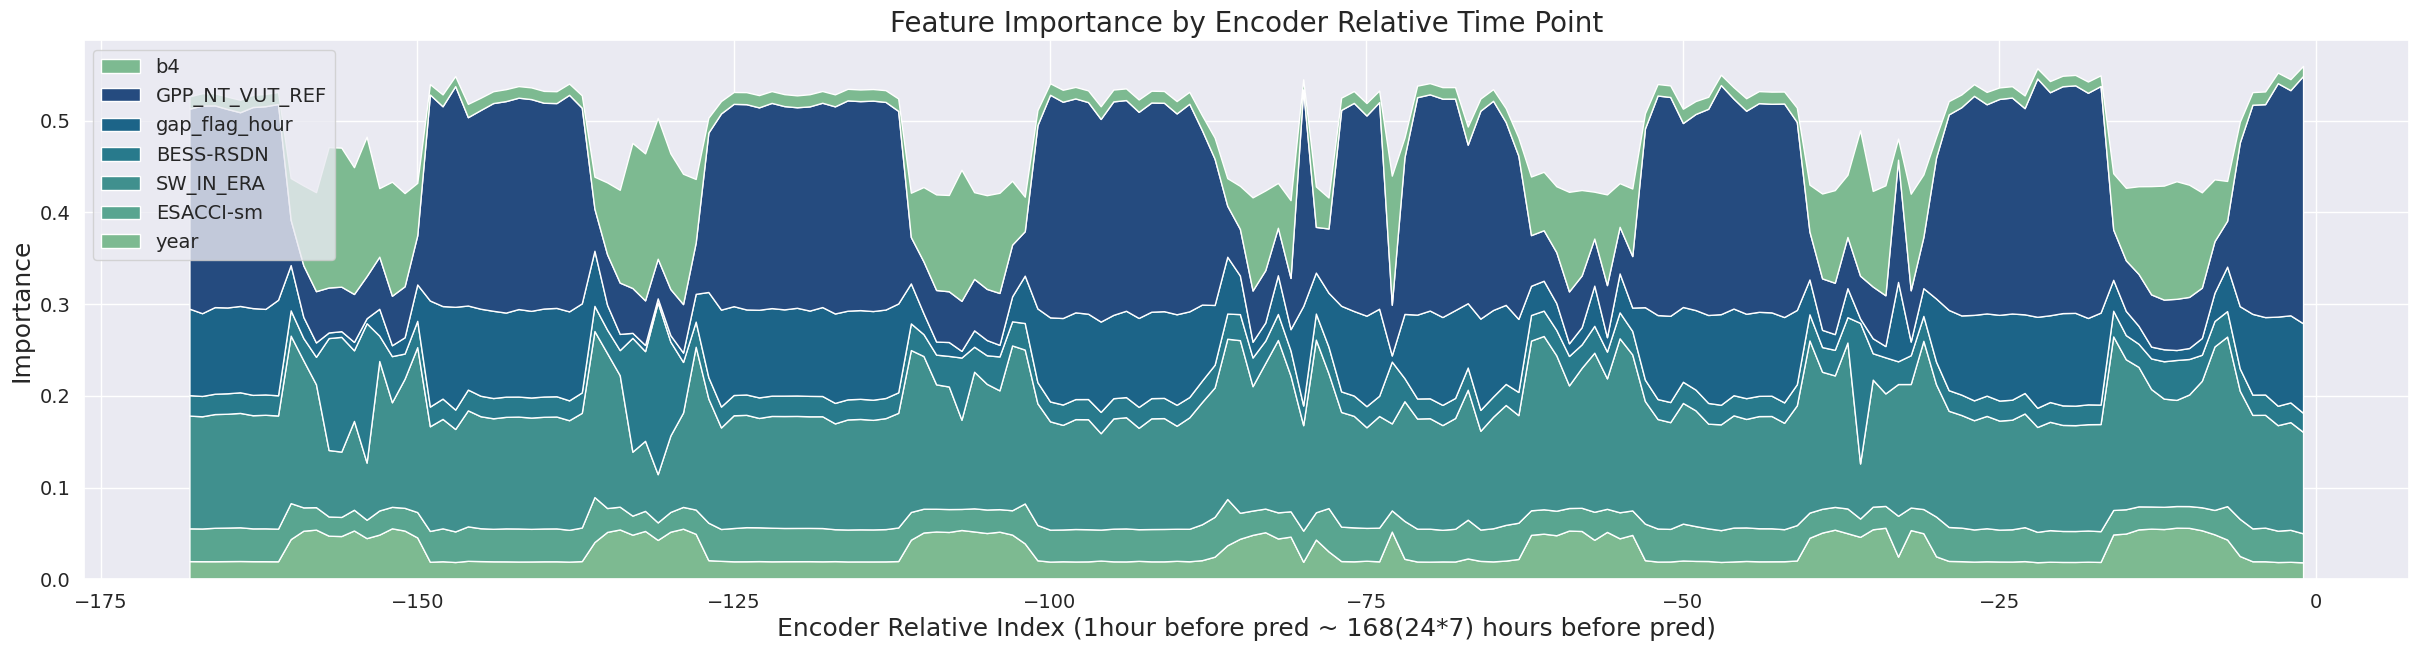

In [366]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn style
sns.set_theme()
pal = sns.color_palette("crest")
sns.set(rc={'figure.figsize':(30,7), })

#['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       # 'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       # 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA']

#create area chart
plt.stackplot(encoder_size_imp_df['encoder_index'], # x axis
              encoder_size_imp_df['year'],
              encoder_size_imp_df['ESACCI-sm'],
              encoder_size_imp_df['SW_IN_ERA'],
              encoder_size_imp_df['BESS-RSDN'],
              encoder_size_imp_df['gap_flag_hour'],
              encoder_size_imp_df['GPP_NT_VUT_REF'],
              encoder_size_imp_df['b4'],
              labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4'],
              colors=pal)

labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4']
# Reverse the order of labels in legend
plt.legend(reversed(plt.legend().legendHandles), reversed(labels), loc='upper left', fontsize=14)

#add axis labels
plt.title('Feature Importance by Encoder Relative Time Point', fontsize=20)
plt.ylabel('Importance', fontsize=18)
plt.xlabel('Encoder Relative Index (1hour before pred ~ 168(24*7) hours before pred)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14) # fontsize of both axes


## Add attention to the plot 

In [367]:
val_raw_predictions["encoder_attention"].shape

torch.Size([223392, 1, 1, 168])

In [368]:
val_raw_predictions["encoder_attention"][0].shape

torch.Size([1, 1, 168])

In [369]:
val_raw_predictions["encoder_attention"][0][0][0].shape

torch.Size([168])

In [370]:
val_raw_predictions["encoder_attention"][0][0][0].numpy()

array([4.18984191e-03, 2.35552987e-04, 9.90402768e-05, 1.26092302e-04,
       3.91928799e-04, 8.98619241e-04, 1.27736107e-03, 2.53990816e-04,
       5.46683550e-05, 2.84913967e-05, 4.51368896e-06, 2.04769412e-06,
       1.17047432e-06, 4.71465285e-07, 2.75374077e-07, 4.80306312e-07,
       1.54025884e-07, 1.82108565e-07, 4.30915946e-07, 4.48896253e-06,
       5.81345303e-05, 2.89538584e-04, 9.01648658e-04, 9.25376429e-04,
       1.19174412e-03, 1.97169790e-03, 2.77570821e-03, 3.96753196e-03,
       7.34838843e-03, 1.40915588e-02, 1.99868158e-02, 9.38517565e-04,
       3.10702271e-05, 6.24297354e-06, 2.96880353e-06, 1.11691804e-06,
       5.45155956e-07, 3.55884396e-07, 3.24886116e-07, 5.28164151e-07,
       1.21089863e-06, 3.92193124e-06, 1.44614187e-05, 1.05347826e-04,
       5.27780503e-04, 9.27169167e-04, 1.21819705e-03, 1.38828903e-03,
       1.49875891e-03, 2.16549146e-03, 3.03296279e-03, 3.78678623e-03,
       7.74025358e-03, 1.33164516e-02, 1.62372291e-02, 3.61783500e-03,
      

In [371]:
# Add attention to feature importance df
encoder_size_imp_df["encoder_attention"] = list(val_raw_predictions["encoder_attention"][0][0][0].numpy())
encoder_size_imp_df.head()

,encoder_index,year,month,day,hour,gap_flag_month,gap_flag_hour,timestep_idx_global,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7,BESS-PAR,BESS-PARdiff,BESS-RSDN,CSIF-SIFdaily,PET,Ts,ESACCI-sm,NDWI,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,relative_time_idx,GPP_NT_VUT_REF,encoder_attention
0,-168,0.01975,0.01695,0.00222,0.00744,0.00867,0.09434,0.02045,0.02397,0.12294,0.02738,0.02498,0.00461,0.02564,0.01595,0.02031,0.00123,0.02050,0.02651,0.00482,0.01342,0.02235,0.02409,0.01167,0.02168,0.00579,0.02226,0.00626,0.02067,0.00586,0.03573,0.02106,0.00171,0.02094,0.00585,0.01984,0.00442,0.02968,0.21806,0.00419
1,-167,0.01967,0.01688,0.00222,0.00720,0.00839,0.09022,0.02021,0.02308,0.12234,0.02741,0.02498,0.00473,0.02531,0.01532,0.02019,0.00122,0.02040,0.02758,0.00473,0.01351,0.02228,0.02402,0.01178,0.02053,0.00584,0.02217,0.00627,0.02059,0.00560,0.03566,0.02098,0.00171,0.02111,0.00577,0.01975,0.00444,0.02957,0.22633,0.00024
2,-166,0.01965,0.01684,0.00224,0.00722,0.00836,0.09447,0.02021,0.02340,0.12397,0.02717,0.02483,0.00474,0.02558,0.01553,0.02023,0.00125,0.02042,0.02707,0.00484,0.01328,0.02222,0.02390,0.01176,0.02126,0.00578,0.02215,0.00617,0.02058,0.00591,0.03647,0.02096,0.00170,0.02054,0.00574,0.01975,0.00438,0.02953,0.21989,0.00010
3,-165,0.01978,0.01690,0.00223,0.00730,0.00845,0.09356,0.02040,0.02418,0.12409,0.02712,0.02486,0.00468,0.02597,0.01578,0.02040,0.00125,0.02057,0.02720,0.00486,0.01343,0.02236,0.02392,0.01160,0.02157,0.00584,0.02232,0.00633,0.02075,0.00587,0.03659,0.02111,0.00171,0.02083,0.00575,0.01991,0.00440,0.02974,0.21639,0.00013
4,-164,0.01989,0.01698,0.00222,0.00741,0.00865,0.09416,0.02054,0.02482,0.12471,0.02719,0.02493,0.00463,0.02614,0.01606,0.02050,0.00126,0.02067,0.02727,0.00489,0.01360,0.02245,0.02399,0.01149,0.02202,0.00582,0.02246,0.00639,0.02088,0.00597,0.03677,0.02124,0.00171,0.02097,0.00578,0.02004,0.00437,0.02992,0.21121,0.00039


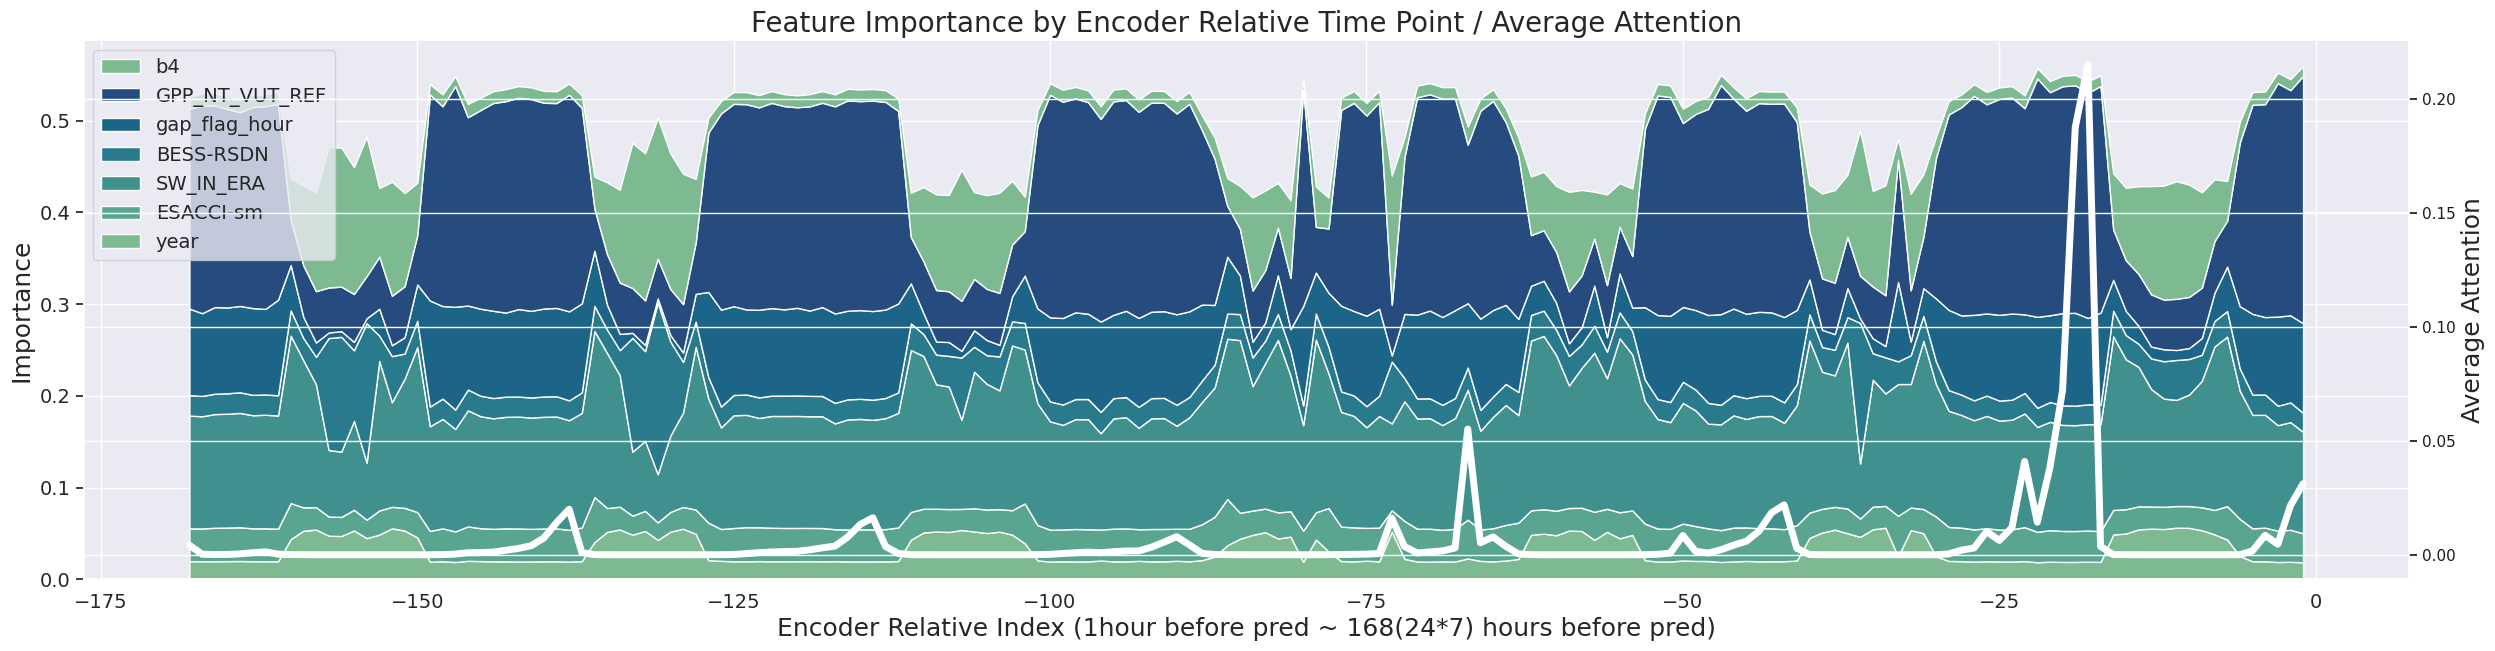

<Figure size 3000x700 with 0 Axes>

In [456]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn style
sns.set_theme()
pal = sns.color_palette("crest")
sns.set(rc={'figure.figsize':(30,7)})

#['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       # 'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       # 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA']

#create area chart
plt.stackplot(encoder_size_imp_df['encoder_index'], # x axis
              encoder_size_imp_df['year'],
              encoder_size_imp_df['ESACCI-sm'],
              encoder_size_imp_df['SW_IN_ERA'],
              encoder_size_imp_df['BESS-RSDN'],
              encoder_size_imp_df['gap_flag_hour'],
              encoder_size_imp_df['GPP_NT_VUT_REF'],
              encoder_size_imp_df['b4'],
              labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4'],
              colors=pal)

labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4']
# Reverse the order of labels in legend
plt.legend(reversed(plt.legend().legendHandles), reversed(labels), loc='upper left', fontsize=14)

#add axis labels
plt.title('Feature Importance by Encoder Relative Time Point / Average Attention', fontsize=20)
plt.ylabel('Importance', fontsize=18)
plt.xlabel('Encoder Relative Index (1hour before pred ~ 168(24*7) hours before pred)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14) # fontsize of both axes

plt2 = plt.twinx()

plt2.plot(encoder_size_imp_df["encoder_index"], encoder_size_imp_df["encoder_attention"], color='w', linewidth=5)
plt2.set_ylabel('Average Attention', fontsize=18)
plt2.tick_params('y', colors='k')
plt.show()
plt.savefig('fi_avg_attention_GPP_TFT_AU-DaP_78_20100108_0AM_0.png')

### (with different palette)

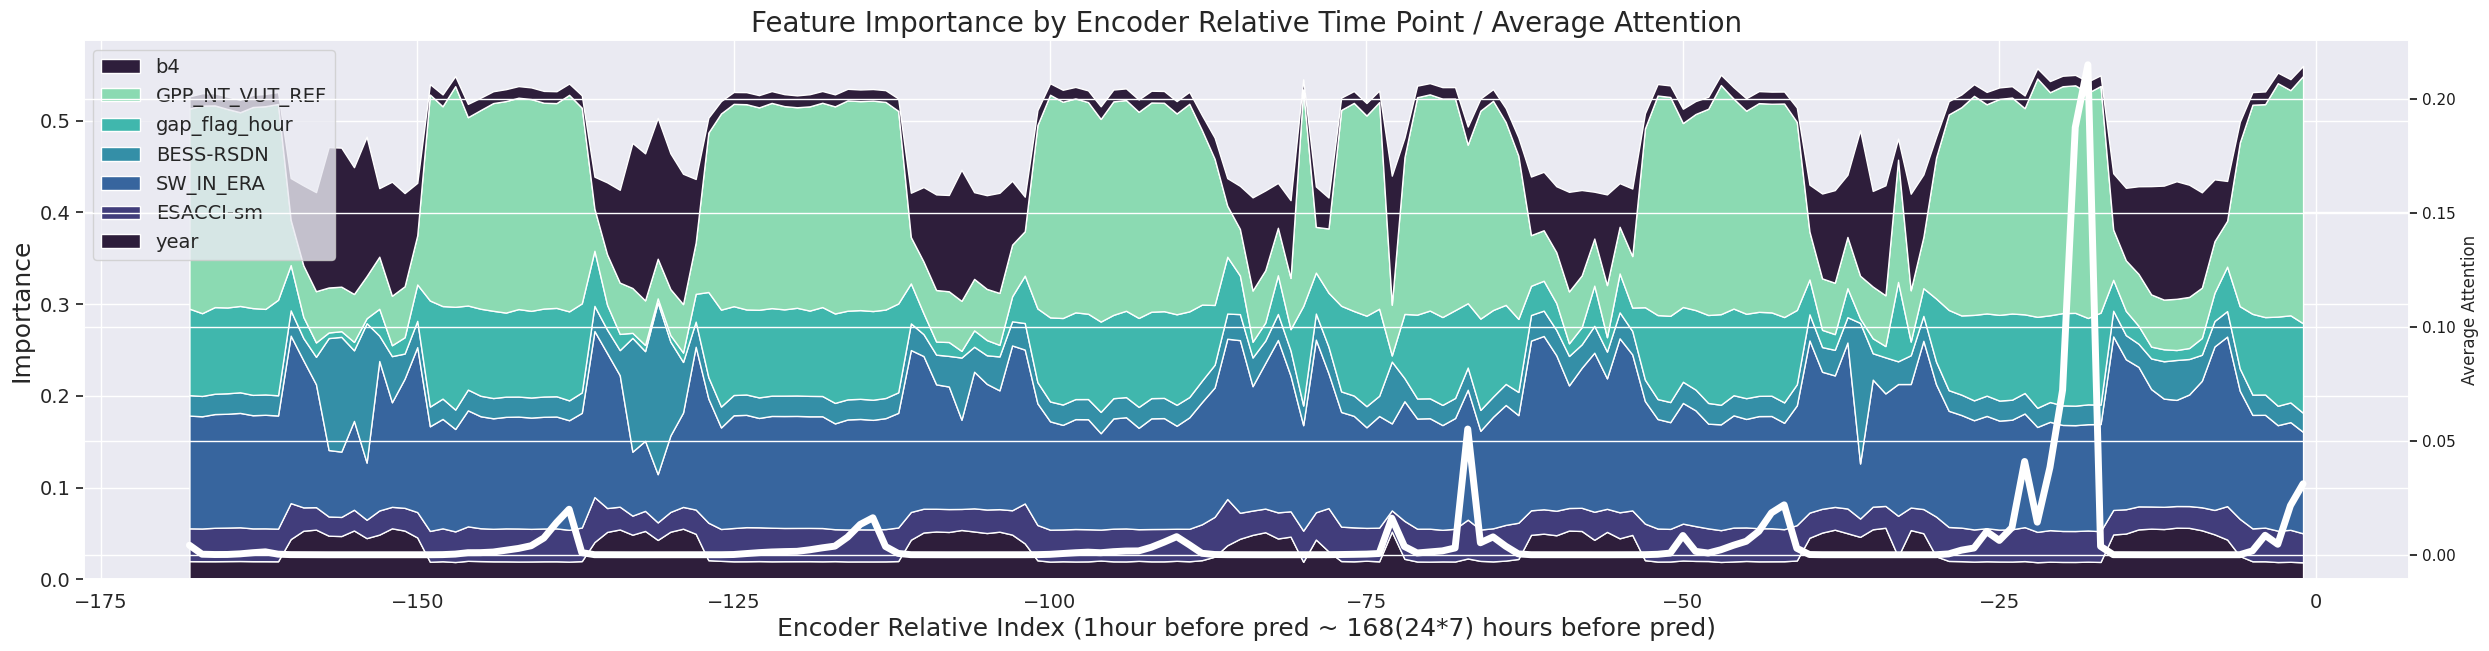

<Figure size 3000x700 with 0 Axes>

In [457]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn style
sns.set_theme()
# pal = sns.light_palette("seagreen")
pal = sns.color_palette("mako")
# pal = sns.cubehelix_palette(start=.5, rot=-.75)#, as_cmap=True)`
# pal = sns.cubehelix_palette(start=.5, rot=-.5)#, as_cmap=True)`
# pal = sns.color_palette("crest")
sns.set(rc={'figure.figsize':(30,7)})

#['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       # 'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       # 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA']

#create area chart
plt.stackplot(encoder_size_imp_df['encoder_index'], # x axis
              encoder_size_imp_df['year'],
              encoder_size_imp_df['ESACCI-sm'],
              encoder_size_imp_df['SW_IN_ERA'],
              encoder_size_imp_df['BESS-RSDN'],
              encoder_size_imp_df['gap_flag_hour'],
              encoder_size_imp_df['GPP_NT_VUT_REF'],
              encoder_size_imp_df['b4'],
              labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4'],
              colors=pal)

labels=['year','ESACCI-sm','SW_IN_ERA','BESS-RSDN','gap_flag_hour','GPP_NT_VUT_REF','b4']
# Reverse the order of labels in legend
plt.legend(reversed(plt.legend().legendHandles), reversed(labels), loc='upper left', fontsize=14)

#add axis labels
plt.title('Feature Importance by Encoder Relative Time Point / Average Attention', fontsize=20)
plt.ylabel('Importance', fontsize=18)
plt.xlabel('Encoder Relative Index (1hour before pred ~ 168(24*7) hours before pred)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14) # fontsize of both axes

plt2 = plt.twinx()

plt2.plot(encoder_size_imp_df["encoder_index"], encoder_size_imp_df["encoder_attention"], color='w', linewidth=5)
plt2.set_ylabel('Average Attention')
plt2.tick_params('y', colors='k')# black is k
plt.show()

plt.savefig('fi_avg_attention_GPP_TFT_AU-DaP_78_20100108_0AM.png')

## Plot without GPP

In [388]:
encoder_size_imp_rank_df[:15].index

Index(['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA'],
      dtype='object')

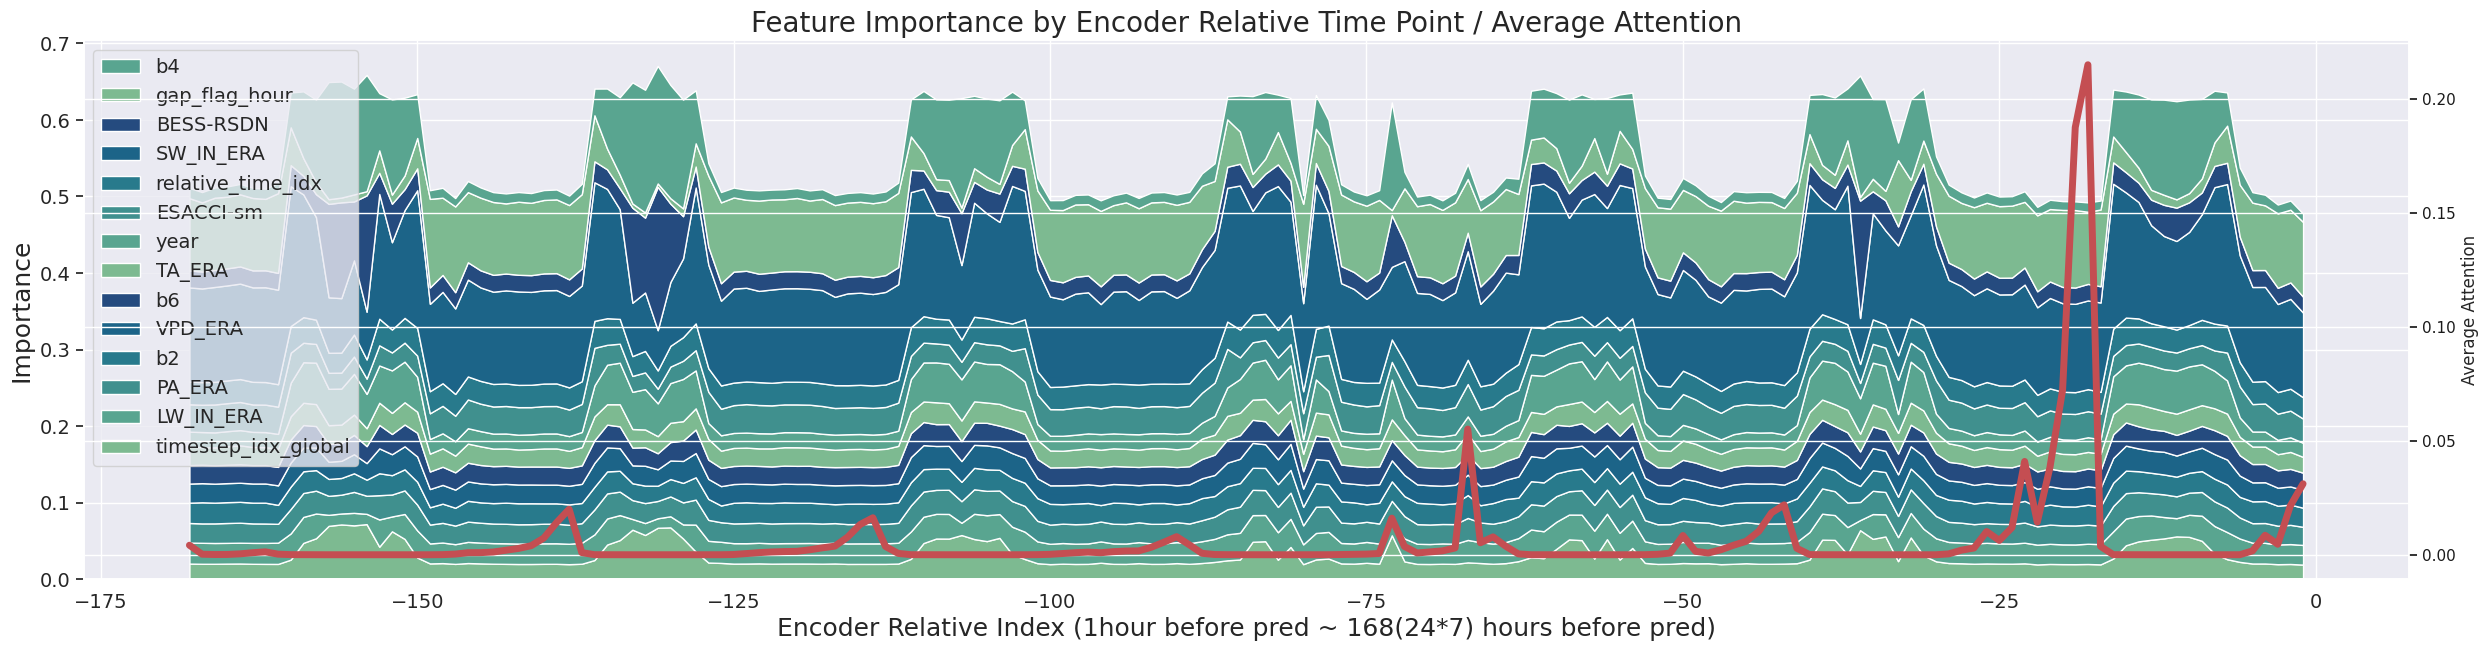

<Figure size 3000x700 with 0 Axes>

In [458]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn style
sns.set_theme()
# pal = sns.light_palette("seagreen")
# pal = sns.color_palette("mako")
# pal = sns.cubehelix_palette(start=.5, rot=-.75)#, as_cmap=True)`
# pal = sns.cubehelix_palette(start=.5, rot=-.5)#, as_cmap=True)`
pal = sns.color_palette("crest")
sns.set(rc={'figure.figsize':(30,7)})

#['GPP_NT_VUT_REF', 'SW_IN_ERA', 'gap_flag_hour', 'b4', 'ESACCI-sm',
       # 'year', 'BESS-RSDN', 'relative_time_idx', 'timestep_idx_global',
       # 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA']

#create area chart
plt.stackplot(encoder_size_imp_df['encoder_index'], # x axis
              encoder_size_imp_df['timestep_idx_global'],
              encoder_size_imp_df['LW_IN_ERA'],
              encoder_size_imp_df['PA_ERA'],
              encoder_size_imp_df['b2'],
              encoder_size_imp_df['VPD_ERA'],
              encoder_size_imp_df['b6'],
              encoder_size_imp_df['TA_ERA'],
              encoder_size_imp_df['year'],
              encoder_size_imp_df['ESACCI-sm'],
              encoder_size_imp_df['relative_time_idx'],
              encoder_size_imp_df['SW_IN_ERA'],
              encoder_size_imp_df['BESS-RSDN'],
              encoder_size_imp_df['gap_flag_hour'],
              encoder_size_imp_df['b4'], 
              labels=['timestep_idx_global', 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA',
                      'year','ESACCI-sm','relative_time_idx', 'SW_IN_ERA','BESS-RSDN','gap_flag_hour','b4'],
              colors=pal)

labels=['timestep_idx_global', 'LW_IN_ERA', 'PA_ERA', 'b2', 'VPD_ERA', 'b6', 'TA_ERA',
        'year','ESACCI-sm','relative_time_idx', 'SW_IN_ERA','BESS-RSDN','gap_flag_hour','b4']
# Reverse the order of labels in legend
plt.legend(reversed(plt.legend().legendHandles), reversed(labels), loc='upper left', fontsize=14)

#add axis labels
plt.title('Feature Importance by Encoder Relative Time Point / Average Attention', fontsize=20)
plt.ylabel('Importance', fontsize=18)
plt.xlabel('Encoder Relative Index (1hour before pred ~ 168(24*7) hours before pred)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14) # fontsize of both axes

plt2 = plt.twinx()

plt2.plot(encoder_size_imp_df["encoder_index"], encoder_size_imp_df["encoder_attention"], color='r', linewidth=5)
plt2.set_ylabel('Average Attention')
plt2.tick_params('y', colors='k')# black is k
plt.show()

plt.savefig('fi_avg_attention_GPP_TFT_AU-DaP_78_20100108_0AM_2.png')

### Prediction time point of the plot

In [413]:
# val_raw_predictions
print(val_x.keys())
val_x["decoder_time_idx"][0].numpy()[0]

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])


350808

In [418]:
val_x["groups"][0].numpy()[0]

78

In [448]:
val_df[val_df["timestep_idx_global"] == val_x["decoder_time_idx"][0].numpy()[0]].head()


,GPP_NT_VUT_REF,site_id,timestep_idx_local,timestep_idx_global,datetime,date,year,month,day,hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,lat,long,koppen_sub,koppen_main,c3c4,c4_percent,BESS-PAR,BESS-PARdiff,BESS-RSDN,CSIF-SIFdaily,PET,Ts,ESACCI-sm,MODIS_LC,NDWI,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,MODIS_IGBP,MODIS_PFT,gap_flag_hour,gap_flag_month
153696,0.27459,AU-DaP,168,350808,2010-01-08,2010-01-08,2010,1,8,0,24.64500,0.00000,421.98300,1.48200,0.00000,99.79000,0.70082,0.81637,0.43350,0.05292,0.52944,0.01994,0.09758,0.45206,0.26292,0.09846,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0
280488,0.92735,AU-How,168,350808,2010-01-08,2010-01-08,2010,1,8,0,26.64300,0.00000,419.60800,5.50800,0.06400,99.97500,0.46305,0.69258,0.22848,0.05976,0.32938,0.03168,0.07132,0.31940,0.19382,0.08112,WSA,-12.49430,131.15230,3,1,C3,0.00000,101.00000,59.00000,197.00000,0.32922,-0.00664,301.01460,0.23053,9,0.18545,0.00000,0.61000,2.20000,307.62000,297.90000,SAV,SA,0.0,0.0
712632,-0.03019,CA-Ca1,168,350808,2010-01-08,2010-01-08,2010,1,8,0,3.10800,0.00000,327.24000,0.47100,0.51300,98.07300,0.31833,0.88657,0.14008,0.00950,0.15800,0.00650,0.01660,0.15650,0.02010,0.02010,ENF,49.86730,-125.33360,15,3,C3,0.02000,53.80000,27.20000,117.80000,0.15050,-0.00897,276.47195,0.25653,1,0.32164,3.60574,0.65600,1.94000,278.48800,272.93200,ENF,ENF,0.0,1.0
782736,-0.14239,CA-Gro,168,350808,2010-01-08,2010-01-08,2010,1,8,0,-16.48100,0.00000,231.30200,0.62600,0.02200,97.86000,0.25928,0.53078,0.09016,0.05248,0.16934,0.04806,0.05364,0.14872,0.06176,0.03260,MF,48.21670,-82.15560,26,4,C3,0.00000,17.00000,10.00000,38.00000,0.04188,-0.00204,260.59857,0.22130,5,0.61799,39.48557,0.46000,0.70000,258.08000,253.30000,MF,MF,0.0,0.0
1204176,-0.16597,CH-Oe2,168,350808,2010-01-08,2010-01-08,2010,1,8,0,-4.02100,0.00000,287.44900,0.00000,0.01600,95.37400,0.27723,0.56114,0.13075,0.06550,0.23300,0.01540,0.06860,0.24720,0.17400,0.10080,CRO,47.28642,7.73375,26,4,C3,0.11000,14.00000,10.00000,29.00000,0.04137,-0.00059,268.11615,0.41293,12,0.12964,16.87276,0.31000,0.40000,274.06000,265.64000,CRO,CRO,0.0,0.0


In [435]:
# val_x["decoder_time_idx"]
val_df[val_df["site_id"] == "AU-DaP"][val_df["timestep_idx_global"] >= 350808]


,GPP_NT_VUT_REF,site_id,timestep_idx_local,timestep_idx_global,datetime,date,year,month,day,hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,lat,long,koppen_sub,koppen_main,c3c4,c4_percent,BESS-PAR,BESS-PARdiff,BESS-RSDN,CSIF-SIFdaily,PET,Ts,ESACCI-sm,MODIS_LC,NDWI,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,MODIS_IGBP,MODIS_PFT,gap_flag_hour,gap_flag_month
153696,0.27459,AU-DaP,168,350808,2010-01-08 00:00:00,2010-01-08,2010,1,8,0,24.64500,0.00000,421.98300,1.48200,0.00000,99.79000,0.70082,0.81637,0.43350,0.05292,0.52944,0.01994,0.09758,0.45206,0.26292,0.09846,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0
153697,-0.52453,AU-DaP,169,350809,2010-01-08 01:00:00,2010-01-08,2010,1,8,1,24.47500,0.00000,420.76000,1.09500,0.00000,99.77100,0.62277,0.78631,0.36462,0.05436,0.46172,0.02206,0.09114,0.42984,0.27454,0.11196,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0
153698,0.09308,AU-DaP,170,350810,2010-01-08 02:00:00,2010-01-08,2010,1,8,2,24.38700,0.00000,420.76000,1.02000,0.00000,99.74500,0.61099,0.75421,0.35564,0.06264,0.46478,0.02708,0.09614,0.42738,0.28264,0.11640,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0
153699,0.48855,AU-DaP,171,350811,2010-01-08 03:00:00,2010-01-08,2010,1,8,3,24.29900,0.00000,420.76000,0.94500,0.00000,99.71900,0.60719,0.75628,0.34824,0.06094,0.45440,0.02720,0.09528,0.42820,0.27558,0.11424,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0
153700,-0.57363,AU-DaP,172,350812,2010-01-08 04:00:00,2010-01-08,2010,1,8,4,24.23200,0.00000,424.59000,0.90800,0.00000,99.71500,0.67154,0.78500,0.40527,0.05442,0.50080,0.02424,0.09000,0.43446,0.27956,0.11512,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162283,-0.95535,AU-DaP,8755,359395,2010-12-31 19:00:00,2010-12-31,2010,12,31,19,23.39700,0.00000,412.59800,1.82500,0.00000,99.97600,0.48415,0.72481,0.25458,0.05428,0.34738,0.02146,0.07654,0.39898,0.27684,0.13674,GRA,-14.06330,131.31810,3,1,C3,97.83000,122.00000,62.00000,245.00000,0.39808,-0.00748,302.17468,0.26823,10,-0.04455,0.00000,0.59000,2.20000,313.18000,297.54000,GRA,GRA,0.0,0.0
162284,-1.14196,AU-DaP,8756,359396,2010-12-31 20:00:00,2010-12-31,2010,12,31,20,23.02600,0.00000,412.59800,1.50400,0.00000,100.02800,0.50446,0.73570,0.26787,0.05354,0.35990,0.02174,0.07584,0.40326,0.27582,0.13176,GRA,-14.06330,131.31810,3,1,C3,97.83000,122.00000,62.00000,245.00000,0.39808,-0.00748,302.17468,0.26823,10,-0.04455,0.00000,0.59000,2.20000,313.18000,297.54000,GRA,GRA,0.0,0.0
162285,-1.37262,AU-DaP,8757,359397,2010-12-31 21:00:00,2010-12-31,2010,12,31,21,22.65400,0.00000,412.59800,1.18300,0.01000,100.08000,0.43204,0.70368,0.21838,0.04876,0.30154,0.02062,0.06050,0.33214,0.23698,0.10976,GRA,-14.06330,131.31810,3,1,C3,97.83000,122.00000,62.00000,245.00000,0.39808,-0.00748,302.17468,0.26823,10,-0.04455,0.00000,0.59000,2.20000,313.18000,297.54000,GRA,GRA,0.0,0.0
162286,-0.59692,AU-DaP,8758,359398,2010-12-31 22:00:00,2010-12-31,2010,12,31,22,22.58800,0.00000,408.60200,1.08300,0.00000,100.10000,0.68533,0.79925,0.41485,0.05392,0.51106,0.02348,0.09126,0.44528,0.27520,0.10796,GRA,-14.06330,131.31810,3,1,C3,97.83000,122.00000,62.00000,245.00000,0.39808,-0.00748,302.17468,0.268

In [447]:
# match AU-DaP = 78
print(val_x['groups'][:10])
val_x['decoder_target'][0].numpy()[0]
val_x['decoder_target'][:10]

tensor([[78],
        [78],
        [78],
        [78],
        [78],
        [78],
        [78],
        [78],
        [78],
        [78]])


tensor([[ 0.2746],
        [-0.5245],
        [ 0.0931],
        [ 0.4886],
        [-0.5736],
        [-1.3871],
        [ 0.3802],
        [ 1.5211],
        [ 8.5506],
        [14.2449]])

In [450]:
val_df[val_df["timestep_idx_global"] == val_x["decoder_time_idx"][0].numpy()[0]][val_df["site_id"] == "AU-DaP"]

,GPP_NT_VUT_REF,site_id,timestep_idx_local,timestep_idx_global,datetime,date,year,month,day,hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,lat,long,koppen_sub,koppen_main,c3c4,c4_percent,BESS-PAR,BESS-PARdiff,BESS-RSDN,CSIF-SIFdaily,PET,Ts,ESACCI-sm,MODIS_LC,NDWI,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,MODIS_IGBP,MODIS_PFT,gap_flag_hour,gap_flag_month
153696,0.27459,AU-DaP,168,350808,2010-01-08,2010-01-08,2010,1,8,0,24.64500,0.00000,421.98300,1.48200,0.00000,99.79000,0.70082,0.81637,0.43350,0.05292,0.52944,0.01994,0.09758,0.45206,0.26292,0.09846,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0


### Profile of the plot

- Site: AU-DaP
- group index: 78

- YEAR 2010
- Month 1
- Day 8
- hour 0AM

In [420]:
# # attention
# fig, ax = plt.subplots()
# attention = interpretation_none["attention"][pred_ind].detach().cpu()
# attention = attention / attention.sum(-1).unsqueeze(-1)
# ax.plot(attention)
# ax.set_xlabel("Time index")
# ax.set_ylabel("Attention")
# ax.set_title(f"Attention for Pred Step {i}")
# xticks_locations = range(0, len(attention), 10)
# xticks_labels = range(-len(attention), 0, 10)
# plt.xticks(xticks_locations, xticks_labels)
# plt.show()

In [421]:

# # Interpret Outputs
# interpretation_sum = best_tft.interpret_output(raw_prediction_igbp, reduction="sum")
# best_tft.plot_interpretation(interpretation_sum)

In [422]:
# # Init df
# example_fi_df = pd.DataFrame(columns= ['encoder_timestep'] + known_cat + unknown_cat + known_real + ['relative_time_idx'])

# # Add avg importances to df
# avg_fi_vals = torch.mean(torch.mean(raw_predictions["encoder_variables"].squeeze(), dim=0), dim=0).numpy()
# example_fi_df.loc[len(example_fi_df)] = ['Average'] + list(avg_fi_vals)

# # Get FIs at each step
# for time in range(ENCODER_LEN):
#     feature_means_time = torch.mean(raw_predictions["encoder_variables"].squeeze(), dim=0)[time].numpy()
#     neg_time = time-ENCODER_LEN
#     example_fi_df.loc[len(example_fi_df)] = [neg_time] + list(feature_means_time)

# # Merge in attn vales
# attn_time = torch.mean(raw_predictions["encoder_attention"].squeeze().squeeze(), dim=0)
# example_fi_df['attn_time'] = [np.nan] + list(attn_time.numpy())

In [ ]:
#!conda install jinja2 -y

In [423]:
# # Save out
# example_fi_df.to_csv(root_dir + os.sep + 'data/feature_imp_by_time_igbp_dbp.csv', index=False)

# # Display
# example_fi_df.sort_values('attn_time', ascending=False, inplace=True)
# styled_df = example_fi_df.style.background_gradient(cmap='Greens')
# styled_df